In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import helper
import random
import feature_optimization
import feature_opt_functions as funcs
from indices import *

from scipy.stats import spearmanr, pearsonr

from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import jaccard_score, f1_score, roc_auc_score, log_loss, precision_score, recall_score

In [14]:
def joinData(H, S):
    buffer = np.empty((H.shape[0] + S.shape[0], H.shape[1]))
    buffer[:H.shape[0], :] = H
    buffer[H.shape[0]:, :] = S

    labels = np.empty((H.shape[0] + S.shape[0]), dtype="int8")
    labels[:H.shape[0]] = 0
    labels[H.shape[0]:] = 1

    return buffer, labels

def leaveFinite(data):
    return data[:, (~np.isnan(data).any(axis=0)) & (np.isfinite(data).all(axis=0))]

def prepareData(data):
    return leaveFinite(data).swapaxes(0, 1)

In [15]:
dictOfStressedImageNames = {}
for v in helper.getStressedImagesNames('stress_date.xlsx'):
    if v is not None:
        dictOfStressedImageNames[v[0]] = v[1]

dictOfReferenceImageNames = {}
for v in helper.getStressedImagesNames('reference_date.xlsx'):
    if v is not None:
        dictOfReferenceImageNames[v[0]] = v[1]

avaibleTiles = list(set.intersection(set(dictOfStressedImageNames.keys()), set(dictOfReferenceImageNames.keys())))
avaibleTiles.remove(32)
random.shuffle(avaibleTiles)

totalStressed = 0
numOfStressedPerImage = {}
for tile in avaibleTiles:
    _, _, mask = helper.loadImage(dictOfStressedImageNames[tile], helper.LOAD_IMASK_BIT)
    s = np.sum(mask == 1) # 1 - stressed
    numOfStressedPerImage[tile] = s
    totalStressed += s

print(totalStressed)
print(numOfStressedPerImage)

index = 0
counter = 0
numOfGroups = 2
numOfTilesPerGroup = [0] * numOfGroups
thresholdCount = totalStressed // numOfGroups
for tile in avaibleTiles:
    numOfTilesPerGroup[index] += 1
    counter += numOfStressedPerImage[tile]
    if (counter > thresholdCount):
        index += 1
        counter = 0

index = 0
tilesPerGroup = [None] * numOfGroups
for i in range(len(numOfTilesPerGroup)):
    num = numOfTilesPerGroup[i]
    tilesPerGroup[i] = avaibleTiles[index:index+num]
    index += num

    c = 0
    for t in tilesPerGroup[i]:
        c += numOfStressedPerImage[t]

    print(f"Group {i}: stressed = {c} tiles = {tilesPerGroup[i]}")

(92, 4)
(92, 4)
31598
{54: 914, 92: 416, 67: 500, 74: 823, 9: 681, 47: 518, 62: 574, 15: 261, 50: 1091, 40: 91, 86: 92, 44: 656, 68: 1107, 52: 197, 61: 555, 46: 286, 43: 180, 7: 1336, 1: 634, 41: 74, 17: 555, 53: 205, 39: 259, 81: 413, 36: 249, 45: 117, 0: 904, 87: 230, 35: 965, 55: 243, 60: 41, 26: 260, 82: 1186, 8: 1972, 56: 841, 84: 394, 29: 299, 89: 484, 5: 475, 70: 161, 93: 229, 59: 615, 28: 801, 77: 1144, 69: 287, 57: 96, 11: 628, 16: 654, 48: 197, 83: 36, 38: 317, 24: 265, 20: 1038, 3: 991, 88: 317, 58: 126, 4: 974, 75: 413, 37: 407, 10: 824}
Group 0: stressed = 16613 tiles = [54, 92, 67, 74, 9, 47, 62, 15, 50, 40, 86, 44, 68, 52, 61, 46, 43, 7, 1, 41, 17, 53, 39, 81, 36, 45, 0, 87, 35, 55, 60, 26, 82]
Group 1: stressed = 14985 tiles = [8, 56, 84, 29, 89, 5, 70, 93, 59, 28, 77, 69, 57, 11, 16, 48, 83, 38, 24, 20, 3, 88, 58, 4, 75, 37, 10]


In [16]:
save_path = "runs/mlp-2-ga-bands+normp4_f24"

clf_factory = lambda: MLPClassifier(tol=1e-4, alpha=1e-4, learning_rate="adaptive", activation='relu', hidden_layer_sizes=(12, 4), shuffle=True, early_stopping=True, max_iter=250)
predict_metrics = [("f1", lambda true_label, predict_label: f1_score(true_label, predict_label, average = None)),
				   ("f1macro", lambda true_label, predict_label: f1_score(true_label, predict_label, average = "macro")),
					 ("iou", jaccard_score),
					 ("precision", precision_score),
					 ("recall", recall_score)]
predict_proba_metrics = [("log-loss", log_loss),
						 ("roc_auc", roc_auc_score)]
metrics_to_print = ["precision", "recall", "f1", "f1macro", "iou", "log-loss", "roc_auc"]

def getIndices(train_data, train_data_ref):
	args = { "num_generations":250, "num_parents_mating":3,
					"parent_selection_type":"sss",
					"crossover_type":"uniform",
				"keep_parents":0,
			"keep_elitism":0,
		 "sol_per_pop":250,
		"mutation_probability":0.22,
	 "parallel_processing":8
	 }

	opt = feature_optimization.FeatureOptimizer([NORMP4, FRAC4, NORMP3, B],
											 12, 16, 
											 funcs.bhattacharyya_distance, 
											 funcs.spearman_independency, 
											 #const_features=[B([i]) for i in range(12)],
											 optimization_method="genetic", 
											 optimizer_args=args,
											 informativeness_threshold=0.1, 
											 independency_threshold=0.4)
	data = [None]*2
	data[0] = leaveFinite(train_data[0])
	data[1] = leaveFinite(train_data[1])
	opt.fit(data, data[1])
	#opt.fit(data, joinData(data[0].swapaxes(0, 1), data[1].swapaxes(0, 1))[0].swapaxes(0, 1))

	return opt

indices_factory = getIndices

In [17]:
import json
import joblib
import os

if (not os.path.exists(save_path)):
    os.makedirs(save_path)

for i in range(numOfGroups):
    subpath = os.path.join(save_path, f"val_{i}")
    if not os.path.exists(subpath):
        os.makedirs(subpath)

with open(os.path.join(save_path, "tiles.json"), 'w') as fout:
    json.dump(tilesPerGroup, fout)

metric_matrix = [[0]*numOfGroups for i in range(len(tilesPerGroup))]

i = 0

validation_tiles = tilesPerGroup[i]
train_tiles = []
for j in range(len(tilesPerGroup)):
    if i != j:
        train_tiles += tilesPerGroup[j]

train_data = helper.getH_and_S(dictOfStressedImageNames, train_tiles)
train_data_ref = helper.getH_and_S(dictOfReferenceImageNames, train_tiles)
test_data = helper.getH_and_S(dictOfStressedImageNames, validation_tiles)
test_data_ref = helper.getH_and_S(dictOfReferenceImageNames, validation_tiles)

print(f"G{i}: Start indices selection")
indices = indices_factory(train_data, train_data_ref)
print("\n")
print(f"G{i}: Indices selection finished")

indices_train_H = leaveFinite(indices.transform_series([train_data[0], train_data_ref[0]])).swapaxes(0, 1)
indices_train_S = leaveFinite(indices.transform_series([train_data[1], train_data_ref[1]])).swapaxes(0, 1)

scaler = RobustScaler(unit_variance=True)
indices_train_H = scaler.fit_transform(indices_train_H)
indices_train_S = scaler.transform(indices_train_S)

indices.save_to("hello.indices")

G0: Start indices selection
Count: 20736 12 4
Count: 20736 12 4
Count: 1728 12 3
Count: 12 12 1


c:\Users\yevhe\mambaforge\envs\swiftt\Lib\site-packages\pygad\pygad.py:895: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")




G0: Indices selection finished


1.0795918965914728
0 0.6331222037393966 <indices.NORMP4 object at 0x000001E108FD1BD0>
1 0.36712148219720414 <indices.NORMP4 object at 0x000001E108FD1BD0>
2 0.3159202434895253 <indices.NORMP4 object at 0x000001E108FD1BD0>
3 0.14541534537990272 <indices.NORMP4 object at 0x000001E108FD1BD0>
4 0.13945423918667144 <indices.FRAC4 object at 0x000001E108FD1BD0>
5 0.11380535082265693 <indices.FRAC4 object at 0x000001E108FD1BD0>
6 0.11206825080235304 <indices.NORMP4 object at 0x000001E108FD1BD0>
7 0.10371476985436752 <indices.NORMP4 object at 0x000001E108FD1BD0>


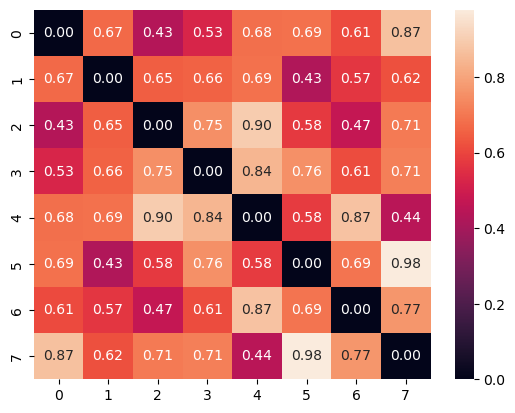

In [18]:
sns.heatmap(indices.get_independency_(), fmt=".2f", annot=True)

print(indices.get_fitness_())

for i in range(len(indices.selected_features)): 
    print(i, indices.soloInformativeness[indices.selected_features[i]], indices.indicesEncoder.getIndex(indices.selected_features[i]))

In [19]:
lhs, rhs = joinData(indices_train_H, indices_train_S)

print(f"G{i}: Start model {j} training")
clf = clf_factory()
clf.fit(lhs, rhs)
# joblib.dump(clf, os.path.join(save_path, f"val_{i}", f"model_{j}.save"))

print(f"G{i}: Start model {j} evaluating")
indices_test_H = leaveFinite(indices.transform_series([test_data[0], test_data_ref[0]])).swapaxes(0, 1)
indices_test_S = leaveFinite(indices.transform_series([test_data[1], test_data_ref[1]])).swapaxes(0, 1)

indices_test_H = scaler.transform(indices_test_H)
indices_test_S = scaler.transform(indices_test_S)

test_lhs, test_rhs = joinData(indices_test_H, indices_test_S)

pred = clf.predict(test_lhs)
pred_proba = clf.predict_proba(test_lhs)[:, 1]

metric_results = {}
for key, metric in predict_metrics:
    metric_results[key] = metric(test_rhs, pred)

for key, metric in predict_proba_metrics:
    metric_results[key] = metric(test_rhs, pred_proba)

for metric in metrics_to_print:
    print(f"{metric}: {metric_results[metric]}")

# metric_matrix[i][j] = metric_results
print("--------------------------------------------------------------------------------")

G7: Start model 1 training
G7: Start model 1 evaluating
precision: 0.6993896236012207
recall: 0.6868621993862841
f1: [0.98006701 0.69306931]
f1macro: 0.8365681595902099
iou: 0.5303030303030303
log-loss: 0.10222231830838092
roc_auc: 0.9598628067439036
--------------------------------------------------------------------------------


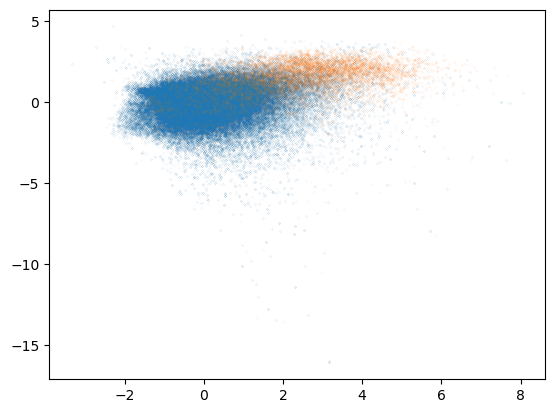

In [20]:
plt.scatter(indices_train_H[:, 1], indices_train_H[:, 2], s=0.001)
plt.scatter(indices_train_S[:, 1], indices_train_S[:, 2], s=0.001)

In [21]:
# df = pd.DataFrame(lhs)
# df["label"] = rhs
# pd.plotting.scatter_matrix(df, c=df["label"], figsize=(30, 30), marker='o', s=1)

In [22]:
opt = feature_optimization.FeatureOptimizer.load_from("hello.indices")
print(opt.get_fitness_())

1.0795918965914728
